# IMPORTING LIBRARIES

In [20]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import KFold
from sklearn import ensemble

# LOADING DATA

The preprocessed data that is prepared using the **EDA_DataPrep.ipynb** notebook is using for training the models.

In [21]:
trainDf = pd.read_csv("./dataset/processedTrain.csv")

# SPLITING DATA

In [22]:
Y = trainDf[['rent']]
X = trainDf.drop(['rent'], axis=1)

In [23]:
trainXDf, testXDf, trainYDf, testYDf = train_test_split(X, Y, test_size=0.33)

# DNN - MODEL ARCHITECTURE

In [24]:
def buildModel(shape=(X.shape[-1], )):
    model = tf.keras.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=shape))
    model.add(layers.Dense(128, activation='relu'))    
    model.add(layers.Dense(256, activation='relu'))    
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(512, activation='relu'))     
    model.add(layers.Dense(256, activation='relu'))  
    model.add(layers.Dense(128, activation='relu')) 
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))  

    model.add(layers.Dense(1, activation='relu'))    
    
    return model

In [25]:
X = X.values
Y = Y.values

## TRAINING

## K-Fold Cross Validation Training

Epoch 1/100
54/54 [==============================] - 2s 19ms/step - loss: 18518.9121 - rmse: 20263.4316 - mape: 98.4017 - val_loss: 16239.3311 - val_rmse: 18092.9336 - val_mape: 85.0412

Epoch 00001: val_rmse improved from inf to 18092.93359, saving model to BestModel_1.h5
Epoch 2/100
54/54 [==============================] - 1s 14ms/step - loss: 7138.4609 - rmse: 9636.3457 - mape: 39.0626 - val_loss: 4540.9028 - val_rmse: 6312.3721 - val_mape: 25.2509

Epoch 00002: val_rmse improved from 18092.93359 to 6312.37207, saving model to BestModel_1.h5
Epoch 3/100
54/54 [==============================] - 1s 15ms/step - loss: 4391.5825 - rmse: 6015.0186 - mape: 24.4612 - val_loss: 4028.2510 - val_rmse: 5623.0850 - val_mape: 22.2376

Epoch 00003: val_rmse improved from 6312.37207 to 5623.08496, saving model to BestModel_1.h5
Epoch 4/100
54/54 [==============================] - 1s 15ms/step - loss: 4107.0630 - rmse: 5612.6377 - mape: 22.6831 - val_loss: 3906.5532 - val_rmse: 5474.0703 - val_mape:

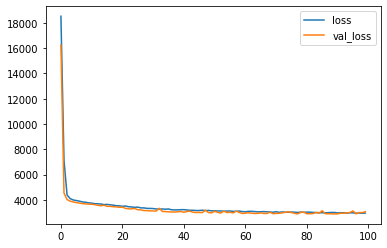

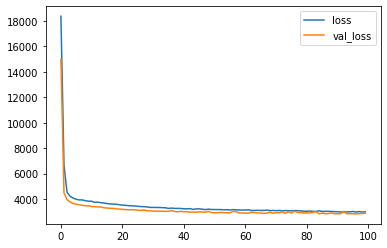

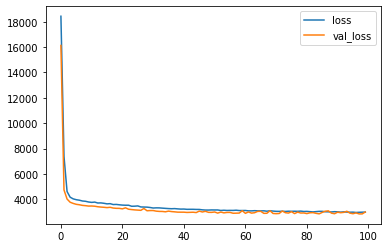

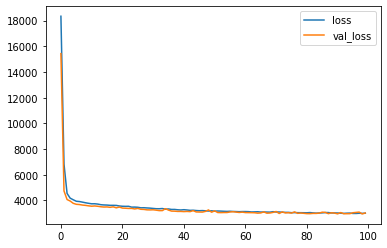

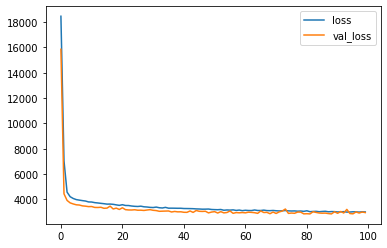

In [26]:
kf = KFold(n_splits=5)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    callbacks = [tf.keras.callbacks.ModelCheckpoint(f"./models/BestModel_{i+1}.h5", 
                   monitor='val_rmse',save_best_only=True, mode="min", verbose=1)] 

    model = buildModel()
    model.compile(loss="mae", optimizer=optimizers.Adam(learning_rate=3e-4), metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),'mape'])

    his = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=256, callbacks=callbacks)
    his = pd.DataFrame(his.history)
    his[['loss', 'val_loss']].plot()

## DNN Model Evaluation

In [27]:
preds = []

for i in range(1, 6):
    model = tf.keras.models.load_model(f"./models/BestModel_{i}.h5")
    pred = model.predict(testXDf).reshape(-1, )
    print(model.evaluate(testXDf, testYDf))
    preds.append(pred)

print("\nDNN Fold - RMSE :", mean_squared_error(testYDf, np.stack(preds).T.mean(axis=-1), squared=False))

177/177 [==============================] - 1s 3ms/step - loss: 2727.1687 - rmse: 3877.0244 - mape: 15.0544
[2727.168701171875, 3877.0244140625, 15.05443000793457]
177/177 [==============================] - 1s 3ms/step - loss: 2690.5312 - rmse: 3843.3879 - mape: 14.6292
[2690.53125, 3843.387939453125, 14.629220008850098]
177/177 [==============================] - 1s 3ms/step - loss: 2671.0952 - rmse: 3786.6521 - mape: 14.8650
[2671.09521484375, 3786.652099609375, 14.864986419677734]
177/177 [==============================] - 1s 3ms/step - loss: 2704.3662 - rmse: 3878.9229 - mape: 14.7944
[2704.3662109375, 3878.9228515625, 14.794367790222168]
177/177 [==============================] - 1s 3ms/step - loss: 2773.3918 - rmse: 3973.3315 - mape: 15.0406
[2773.391845703125, 3973.33154296875, 15.040605545043945]

DNN Fold - RMSE : 3764.9357527642396


## Machine Lerning Models

In [28]:
regGB = ensemble.GradientBoostingRegressor(loss="absolute_error",n_estimators=360)
regGB.fit(trainXDf, trainYDf)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(loss='absolute_error', n_estimators=360)

In [29]:
regRF = ensemble.RandomForestRegressor(n_estimators=360)
regRF.fit(trainXDf, trainYDf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(n_estimators=360)

In [30]:
regET = ensemble.ExtraTreesRegressor(n_estimators=360)
regET.fit(trainXDf, trainYDf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesRegressor(n_estimators=360)

In [31]:
regB = ensemble.BaggingRegressor(n_estimators=360)
regB.fit(trainXDf, trainYDf)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor(n_estimators=360)

## Saving The Models

In [32]:
import joblib

joblib.dump(regGB, './models/regGB.sav')
joblib.dump(regRF, './models/regRF.sav')
joblib.dump(regET, './models/regET.sav')
joblib.dump(regB, './models/regB.sav')

['regB.sav']

In [33]:
GbPred = regGB.predict(testXDf)
RFPred = regRF.predict(testXDf)
ETPred = regET.predict(testXDf)
BPred = regB.predict(testXDf)

In [34]:
print("GB RMSE :", mean_squared_error(testYDf, GbPred, squared=False))
print("RF RMSE :", mean_squared_error(testYDf, RFPred, squared=False))
print("ET RMSE :", mean_squared_error(testYDf, ETPred, squared=False))
print("B RMSE :", mean_squared_error(testYDf, BPred, squared=False))

print("Reg Ensemble RMSE :", mean_squared_error(testYDf, np.stack([GbPred, RFPred, ETPred, BPred]).T.mean(axis=-1), squared=False))

GB RMSE : 3731.0366141644326
RF RMSE : 3773.0240789292047
ET RMSE : 3923.76951817037
B RMSE : 3770.1455382530794
Reg Ensemble RMSE : 3696.164412415954


# Ensembling Predictions

The outputs of 5 folds from DNN.<br>
Outputs from the 4 regrssion models BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, ExtraTreesRegressor.<br>
These 9 outputs are **averaged** for the final result.

In [35]:
print("Full Ensemble RMSE :", mean_squared_error(testYDf, np.stack([GbPred, RFPred, ETPred, BPred]+preds).T.mean(axis=-1), squared=False))

print("Full Ensemble RMSE :", mean_absolute_percentage_error(testYDf, np.stack([GbPred, RFPred, ETPred, BPred]+preds).T.mean(axis=-1)))
print("Full Ensemble RMSE :", mean_absolute_error(testYDf, np.stack([GbPred, RFPred, ETPred, BPred]+preds).T.mean(axis=-1)))

Full Ensemble RMSE : 3653.046653448548
Full Ensemble RMSE : 0.14097396319921263
Full Ensemble RMSE : 2548.950579926645


---